# Breast Cancer Detection

Insight Data Science 

Week 5 Data Challenge

Gwen Yang July 6 2019  

In [26]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report

### load data, remove duplicate, remove missing data, convert data types 

In [16]:
raw = pd.read_csv('breast-cancer-wisconsin.txt', index_col=0)
cols = list(raw)
# print(raw.head())
# print(raw.info())
# print(raw.shape)
#print(cols)

In [17]:
#check duplicate 
print(raw.ID.unique().size)
count = raw.count()
print(count)

666
ID                             15855
Clump Thickness                15855
Uniformity of Cell Size        15827
Uniformity of Cell Shape       15827
Marginal Adhesion              15827
Single Epithelial Cell Size    15827
Bare Nuclei                    15827
Bland Chromatin                15827
Normal Nucleoli                15827
Mitoses                        15827
Class                          15827
dtype: int64


In [18]:
#There are 15855 rows but 666 unique ID. 
#Chech into the duplicate ID, see if all the records are duplicated.
raw['is_duplicated'] = raw.duplicated(['ID'])
print(count.ID-raw.is_duplicated.sum())

raw_nodup = raw.loc[raw['is_duplicated']==False]
data = raw_nodup[cols[0:11]]
data.shape

666


(666, 11)

In [19]:
# deal with missing value
data = data.replace('?', np.nan).dropna(how = 'any') 
data = data.replace('#', np.nan).dropna(how = 'any') 
data = data.replace('No idea', np.nan).dropna(how = 'any') 

# Check data label
#data.groupby(['Class'])['ID'].count()
#Consider class label 20, 40 as typo of 2 and 4. Cnvert class labels.
data.loc[data['Class']=='20', 'Class']='2'
data.loc[data['Class']=='40', 'Class']='4'
print(data.groupby(['Class'])['ID'].count())

data = data.astype('int64')
print(data.dtypes)

Class
2    400
4    249
Name: ID, dtype: int64
ID                             int64
Clump Thickness                int64
Uniformity of Cell Size        int64
Uniformity of Cell Shape       int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object


#### EDA #####

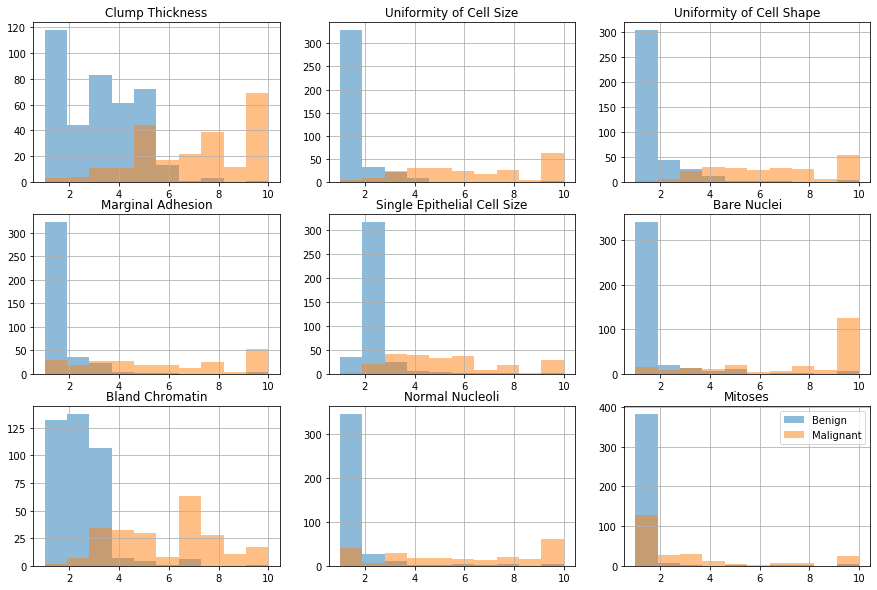

In [20]:
# look at the value distribution 
# draw feature values with in range 1-10
fig = plt.figure()

for col, i in zip(cols[1:10], range(1,10)):
    df = data.loc[data[col] < 11, col]
    ax = fig.add_subplot(3,3,i)
    #ax.title(col)
    df.groupby(data['Class']).hist(bins=10, ax=ax, alpha=0.5, figsize=(15,10),stacked=True)
    ax.set_title(col)
plt.legend(['Benign','Malignant'])

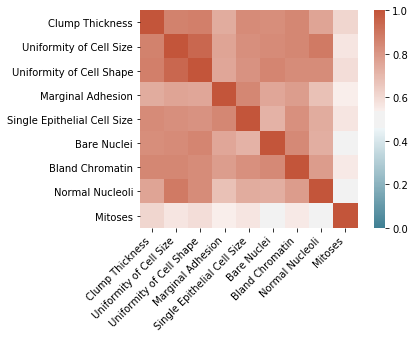

In [22]:
# explore data correlation

data_noIdx = data[cols[1:10]]

corr = data_noIdx.corr()

ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### data standardize and dataset split for cross validations

In [27]:
X = data[cols[1:10]]
y = data.Class
#X = data.drop('Class', axis=1)
# standardize features by removing mean and scaling to unit variance
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# concatenate our training data back together
# X_t = pd.DataFrame(X_train)
y_t = pd.DataFrame(y_train)
X = np.concatenate((X_train, y_t), axis=1)
print(X_train.shape, y_t.shape, X.shape)

Benign = X[X[:,-1]==2]
Malignant = X[X[:,-1]==4]

# separate minority and majority classes
Benign = X[X[:,-1]==2]
Malignant = X[X[:,-1]==4]

# upsample minority
Malignant_upsampled = resample(Malignant,
                              replace=True, # sample with replacement
                              n_samples=len(Benign), # match number in majority class
                              random_state=27) # reproducible results

# combine to classes back
upsampled = np.concatenate((Benign,Malignant_upsampled),axis=0)
# check new class counts
upsampled[:,-1].shape

# prepare for logistic regression again with the balanced dataset
y_train = upsampled[:,-1]
X_train = upsampled[:, :-1]
upsampled.shape

(486, 9) (486, 1) (486, 10)


(620, 10)

### logistic regression with cross validation

In [ ]:
lrcv = LogisticRegressionCV(multi_class='multinomial', cv=5, random_state=33, fit_intercept=True, penalty ='l2', Cs=np.logspace(-2, 2, 20), solver='sag', class_weight ='balanced',tol=0.01)
# multi_class : "ovr" (default). one over rest
# Cs: inverse of regularization. Smaller Cs, stronger regularization
# fit_intercept: intercept 0 or not.
# class_weight : assign weight to class label, i.e. the class has more samples then less class weight

multi_class : "ovr" (default). one over rest

Cs: inverse of regularization. Smaller Cs, stronger regularization

fit_intercept: intercept 0 or not.

class_weight : assign weight to class label, i.e. the class has more samples then less class weight

In [8]:
lrcv.fit(X_train, y_train)
y_pred_cv = lrcv.predict(X_test)
print(classification_report(y_test,y_pred_cv,target_names=['Benign','Malignant']))

y_cv_pred_prob = lrcv.predict_proba(X_test)
print(y_pred_cv[:10])
print(y_cv_pred_prob[:10])

In [ ]:
# plot prediction with probabilities 
y_cv1 = y_cv_pred_prob[:50, 0]
y_cv2 = -y_cv_pred_prob[:50, 1]
xx = np.arange(len(y_cv1))

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(xx, y_cv1, 0.5, label="Benign")
rects2 = ax.bar(xx, y_cv2, 0.5, label="Malignant")
# ax.set_ylabel("Class")
ax.set_yticks([-1,0,1])
ax.set_yticklabels(['Malignant',0, 'Benign'], fontsize=18)
ax.set_title('Prediction by logistic regression CV',fontsize=20)
ax.grid()

In [ ]:
#cols[1:10]
xx = np.array(cols[1:10])
yy = np.array(lrcv.coef_[0])

fig, ax = plt.subplots(figsize=(10,5))
importance = ax.bar(xx, yy, 0.35)

ax.set_xlabel("Features",fontsize=20)
ax.set_xticklabels(cols[1:10], fontsize=14, rotation=30, horizontalalignment='right')
ax.set_yticks([0,2,4])
ax.yaxis.grid()

#### calculate p-value 

In [179]:
from scipy import stats
# y_pred_cv = lrcv.predict(X_test) 
params = np.append(lrcv.intercept_, lrcv.coef_)
newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
MSE = (sum((y_test-y_pred_cv)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["p_values"],myDF3["Standard Errors"],myDF3["t_values"] = [params,p_values,sd_b,ts_b]

print(myDF3)

   Coefficients  p_values  Standard Errors  t_values
0        0.7854     0.000            0.041    19.310
1        0.2356     0.012            0.092     2.549
2        2.0048     0.000            0.143    14.002
3        0.8543     0.000            0.160     5.342
4        1.2561     0.000            0.127     9.874
5        0.4483     0.013            0.178     2.517
6        3.2940     0.000            0.121    27.207
7        0.5197     0.000            0.117     4.426
8        2.1155     0.000            0.146    14.530
9        0.3733     0.000            0.038     9.738
